In [5]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
import time


In [2]:

starttime = time.time()
#reading in GEDI points
gedi_df = gpd.read_file('GEDI_data/4190and4240gedi.gpkg', driver='GPKG', index = True)
endtime = time.time()
print(f"Reading in the GEDI shapefile took {endtime - starttime} seconds")
# print(gedi_df.head())
#reading in ICESat2 shapefile
icesat_df = gpd.read_file('GEDI_data/4190and4240icesat.shp', driver='ESRI Shapefile', index = True)
# print(icesat_df.head())


Reading in the GEDI shapefile took 153.56739830970764 seconds


In [64]:
# Read the CSV file
matches = pd.read_csv('../gedi_icesat_matches_copy.csv')

# # Display the contents of the CSV file
# print(matches)

# Get unique values in GeoTIFF column
unique_geotiffs = matches['GeoTIFF'].unique()

# Specify the file location of the TIFF files
tif_folder = 'reprojected_icesat_to_gedi_crs'

# Create an empty list to store the data
list = []

# Iterate over unique GeoTIFF values
for geotiff in unique_geotiffs:
    # print(geotiff)
    # Construct the file path
    tif_file = os.path.join(tif_folder, geotiff[:-4] + '_reprojected.tif')
    
    # Load the TIFF file using rasterio
    with rasterio.open(tif_file) as icesat_tif:
        # print(icesat_tif)

        filtered_df = matches[matches['GeoTIFF'] == geotiff]

        # Iterate through the "gedi shot number" values
        for gedi_shot_number in filtered_df['gedi shot number']:

            # Search for the row with the specified shot number
            point = gedi_df[gedi_df['shot_numbe'] == gedi_shot_number]

            # print(point)
            # print("GEDI shot number:", gedi_shot_number)

            # Extract the latitude, longitude, and agbd values
            lat = point['lat_lowest'].values[0]
            lon = point['lon_lowest'].values[0]
            agbd_gedi = point['agbd'].values[0]

            # # Print the extracted values
            # print("Latitude:", lat)
            # print("Longitude:", lon)

            row, col = icesat_tif.index(lon, lat)
            abgd_icesat = icesat_tif.read(1)[row, col]

            # print("AGBD icesat:", abgd_icesat)
            # print("AGBD gedi:", agbd_gedi)
            # print("Difference:", abgd_icesat - agbd_gedi)
            # print()

            # Create a dictionary with the data
            data = {
                'Gedi Shot Number': gedi_shot_number,
                'ICESat Tile': geotiff,
                'ICESat AGBD': abgd_icesat,
                'GEDI AGBD': agbd_gedi,
                'Difference': agbd_gedi - abgd_icesat,
                'Latitude': lat,
                'Longitude': lon
            }

            # Append the data to the list
            list.append(data)

#save the dataframe to a csv file
df = pd.DataFrame(list) 
df.to_csv('gedi_icesat_agbd_comparison.csv', index=False)
print("Dataframe saved to csv file")
# print(df.head())  
            
        



Dataframe saved to csv file


10163.958
-135.6766012998047


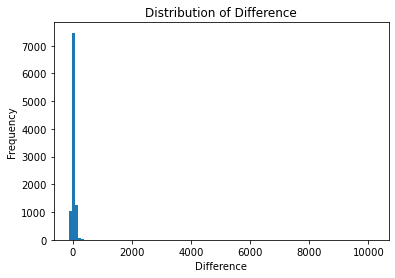

In [61]:
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('gedi_icesat_agbd_comparison.csv')

difference_values = df['Difference'].values

print(max(difference_values))
print(min(difference_values))

# Plotting the distribution of "Difference"
plt.hist(difference_values, bins=100)  # You can adjust the number of bins as needed
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Difference')
plt.show()

99th percentile of difference values:  167.46391272207063
1st percentile of difference values:  -75.62637475390625
Maximum value of difference values:  10163.958
Minimum value of difference values:  -135.6766012998047
Maximum value of filtered difference values:  167.25339840576171
Minimum value of filtered difference values:  -75.60377946289063


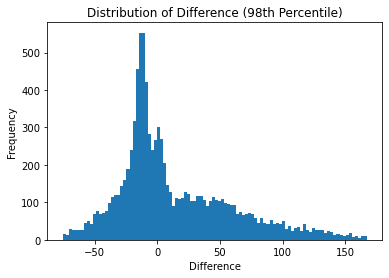

In [62]:
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('gedi_icesat_agbd_comparison.csv')

difference_values = df['Difference'].values

# # Find the indices where difference_values is nan
# nan_indices = np.where(np.isnan(difference_values))
# print(nan_indices)

# Exclude nan values
difference_values = difference_values[~np.isnan(difference_values)]
# Calculate the 99th percentile of the difference values
percentile_99 = np.percentile(difference_values, 99)
percentile_1 = np.percentile(difference_values, 1)

# Filter the difference values to remove outliers
filtered_difference_values = difference_values[difference_values <= percentile_99]
filtered_difference_values = filtered_difference_values[filtered_difference_values >= percentile_1]

print("99th percentile of difference values: ", percentile_99)
print("1st percentile of difference values: ", percentile_1)
print("Maximum value of difference values: ", max(difference_values))
print("Minimum value of difference values: ", min(difference_values))
print("Maximum value of filtered difference values: ", max(filtered_difference_values))
print("Minimum value of filtered difference values: ", min(filtered_difference_values))

# Plotting the distribution of "Difference"
plt.hist(filtered_difference_values, bins=100)  # You can adjust the number of bins as needed
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Difference (98th Percentile)')
plt.show()

/usr/lib/python3/dist-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


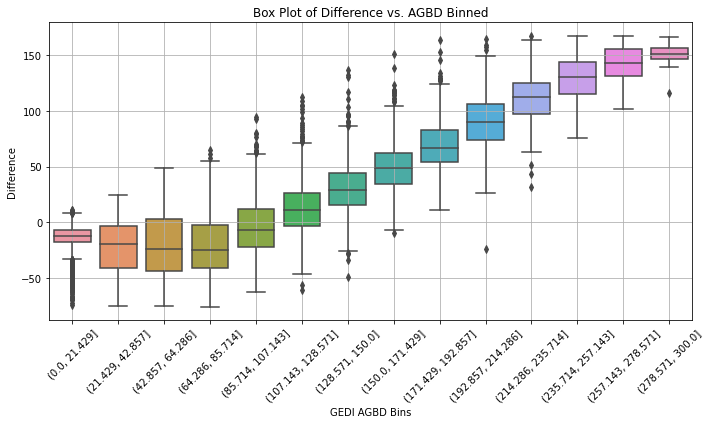

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('gedi_icesat_agbd_comparison.csv')

# Define the bin edges for the 'agbd' variable
start = 0
end = 300
bins = 15
bin_edges = np.linspace(start, end, bins)

# Create a new column 'agbd_bin' that indicates the bin for each value of 'agbd'
df['agbd_bin'] = pd.cut(df['GEDI AGBD'], bins=bin_edges)

# exclude outliers from the df
df = df[df['Difference'] <= percentile_99]
df = df[df['Difference'] >= percentile_1]

# Create the box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='agbd_bin', y='Difference', data=df)
plt.title('Box Plot of Difference vs. AGBD Binned')
plt.xlabel('GEDI AGBD Bins')
plt.ylabel('Difference')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/lib/python3/dist-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


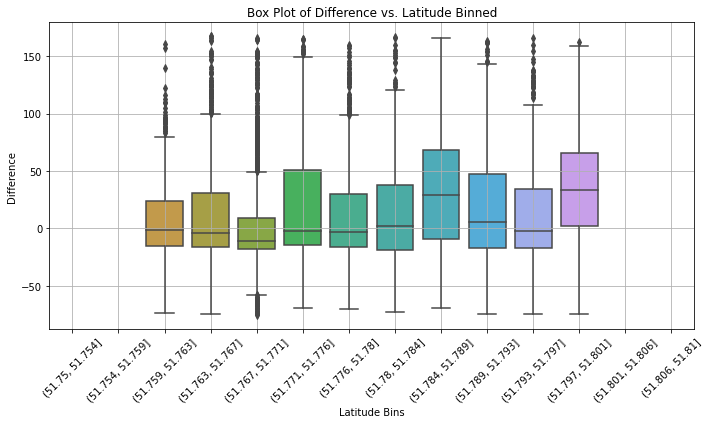

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('gedi_icesat_agbd_comparison.csv')

# Define the bin edges for the 'agbd' variable
start = 51.75
end = 51.81
bins = 15
bin_edges = np.linspace(start, end, bins)

# Create a new column 'latitude_bin' that indicates the bin for each value of 'agbd'
df['latitude_bin'] = pd.cut(df['Latitude'], bins=bin_edges)

# exclude outliers from the df
df = df[df['Difference'] <= percentile_99]
df = df[df['Difference'] >= percentile_1]

# Create the box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='latitude_bin', y='Difference', data=df)
plt.title('Box Plot of Difference vs. Latitude Binned')
plt.xlabel('Latitude Bins')
plt.ylabel('Difference')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/lib/python3/dist-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


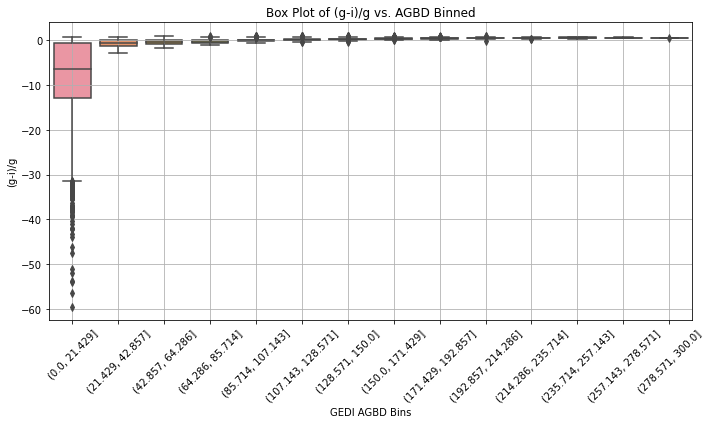

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('gedi_icesat_agbd_comparison.csv')

# Define the bin edges for the 'agbd' variable
start = 0
end = 300
bins = 15
bin_edges = np.linspace(start, end, bins)

df['(g-i)/g'] = (df['GEDI AGBD'] - df['ICESat AGBD'])/df['GEDI AGBD']
# Create a new column 'agbd_bin' that indicates the bin for each value of 'agbd'
df['agbd_bin'] = pd.cut(df['GEDI AGBD'], bins=bin_edges)

# exclude outliers from the df
df = df[df['Difference'] <= percentile_99]
df = df[df['Difference'] >= percentile_1]

# Create the box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='agbd_bin', y='(g-i)/g', data=df)
plt.title('Box Plot of (g-i)/g vs. AGBD Binned')
plt.xlabel('GEDI AGBD Bins')
plt.ylabel('(g-i)/g')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/lib/python3/dist-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


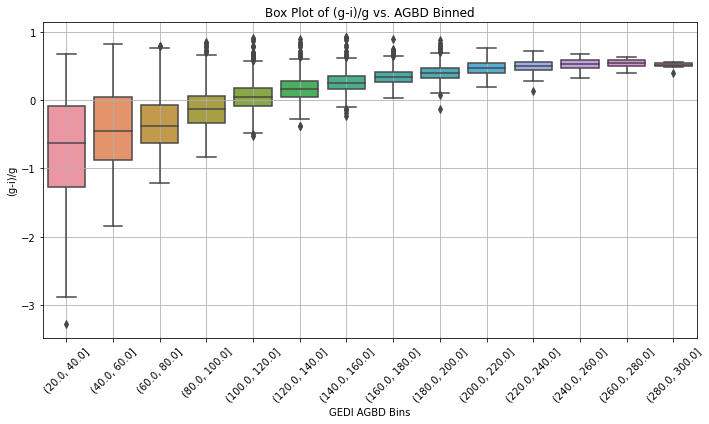

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('gedi_icesat_agbd_comparison.csv')

# Define the bin edges for the 'agbd' variable
start = 20
end = 300
bins = 15
bin_edges = np.linspace(start, end, bins)

df['(g-i)/g'] = (df['GEDI AGBD'] - df['ICESat AGBD'])/df['GEDI AGBD']
# Create a new column 'agbd_bin' that indicates the bin for each value of 'agbd'
df['agbd_bin'] = pd.cut(df['GEDI AGBD'], bins=bin_edges)

# exclude outliers from the df
df = df[df['Difference'] <= percentile_99]
df = df[df['Difference'] >= percentile_1]
df = df[df['(g-i)/g'] >= -15]

# Create the box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='agbd_bin', y='(g-i)/g', data=df)
plt.title('Box Plot of (g-i)/g vs. AGBD Binned')
plt.xlabel('GEDI AGBD Bins')
plt.ylabel('(g-i)/g')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/lib/python3/dist-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


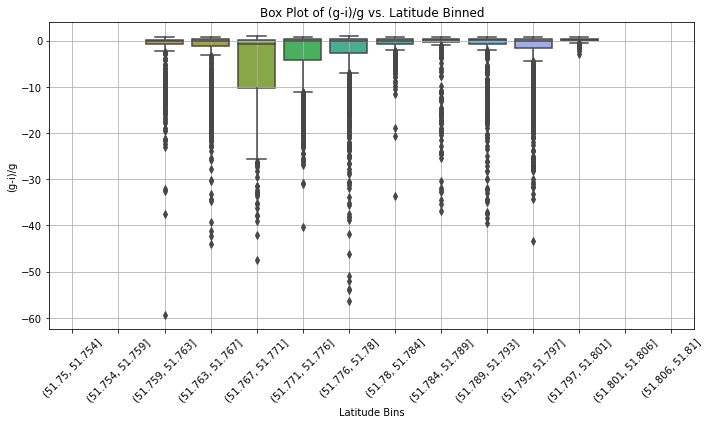

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv('gedi_icesat_agbd_comparison.csv')

# Define the bin edges for the 'agbd' variable
start = 51.75
end = 51.81
bins = 15
bin_edges = np.linspace(start, end, bins)

df['(g-i)/g'] = (df['GEDI AGBD'] - df['ICESat AGBD'])/df['GEDI AGBD']
# Create a new column 'latitude_bin' that indicates the bin for each value of 'agbd'
df['latitude_bin'] = pd.cut(df['Latitude'], bins=bin_edges)

# exclude outliers from the df
df = df[df['Difference'] <= percentile_99]
df = df[df['Difference'] >= percentile_1]

# Create the box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='latitude_bin', y='(g-i)/g', data=df)
plt.title('Box Plot of (g-i)/g vs. Latitude Binned')
plt.xlabel('Latitude Bins')
plt.ylabel('(g-i)/g')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()
